Lets move the hello world to a single parameterized GHZ state. This is important as i can show a Mermin and get a single shot violation. 

I would also like to show that all Quantum Algorithms can be written as

1. Choose a quantum circuit to encode the quantum state
2. Define the output to be measured
3. Execute a primitive (estimator or sampler)

iterative algorithms may call multiple estimators with new quantum circuits or measurement outcomes. 

For Mermin 

1. the input quantum state needs to be GHZ state of the form |000> + e^{phi} |111>
2. The inequality to be measured is XXY + XYX + YXY - YYY
3. Call the estimator.

Alternatively we could 
1. generate the input state |000> + e^{phi} |111>
2. Sample the output of the measurement
3. Call the sampler


In [1]:
# General imports
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
theta = Parameter('θ')


# Step 1. Choose the quantum circuit to make the quantum state |000> + e^{theta} |111>
qc_example = QuantumCircuit(3)
qc_example.h(0) # generate superposition
qc_example.p(theta, 0) # add quantum phase
qc_example.cx(0, 1) # condition 1st qubit on 0th qubit
qc_example.cx(0, 2) # condition 2nd qubit on 0th qubit
qc_example.draw()

┌───┐┌──────┐          
q_0: ┤ H ├┤ P(θ) ├──■────■──
     └───┘└──────┘┌─┴─┐  │  
q_1: ─────────────┤ X ├──┼──
                  └───┘┌─┴─┐
q_2: ──────────────────┤ X ├
                       └───┘

In [2]:
from qiskit.quantum_info import SparsePauliOp

# Step 2: Choose the output to be measured
M1 = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])

print(M1)

SparsePauliOp(['XXY', 'XYX', 'YXX', 'YYY'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])


In [3]:
from qiskit.primitives.estimator import Estimator

#step 3. Choose the primitive function to be executed
estimator = Estimator()

job = estimator.run(qc_example, M1, shots=1000, parameter_values=np.pi/2)
result = job.result()
print(f" > Expectation values: {result.values}")

 > Expectation values: [4.]


Now imagine that you did not know which value of pi/2 maximized the inequality. One way a user could find this is to run many phases and plot the output as a function of the phase variable. However first lets switch to using the the IBM runtime

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Estimator
service = QiskitRuntimeService()

options = Options(optimization_level=1)
options.execution.shots = 5000  # Options can be set using auto-complete.

# batch of theta values to run in a single job with 50 different points 
points = 50
theta1 = []
for x in range(points):
    theta = [x*2.0*np.pi/50]
    theta1.append(theta)
    
backend = service.get_backend('ibmq_qasm_simulator')
estimator = Estimator(backend, options=options)

job = estimator.run(circuits=[qc_example]*points, observables=[M1]*points, parameter_values=theta1)
print(f"Job ID is {job.job_id()}")
print(f"Job result is {job.result().values}")

Job ID is cjrtt2grkbgpt6ur45ug
Job result is [ 5.5600e-02  4.8600e-01  9.9880e-01  1.4412e+00  1.9088e+00  2.3196e+00
  2.7012e+00  3.1080e+00  3.4032e+00  3.6020e+00  3.7972e+00  3.9180e+00
  3.9920e+00  3.9916e+00  3.9212e+00  3.7920e+00  3.5952e+00  3.3464e+00
  3.0624e+00  2.7192e+00  2.3440e+00  1.8836e+00  1.5292e+00  9.8960e-01
  5.3240e-01 -2.0000e-03 -5.7200e-01 -9.8320e-01 -1.5196e+00 -1.9388e+00
 -2.3520e+00 -2.7576e+00 -3.0872e+00 -3.3680e+00 -3.6384e+00 -3.8104e+00
 -3.9396e+00 -3.9920e+00 -3.9936e+00 -3.9324e+00 -3.8208e+00 -3.6104e+00
 -3.3720e+00 -3.1012e+00 -2.7536e+00 -2.3420e+00 -1.8860e+00 -1.4552e+00
 -1.0224e+00 -4.7880e-01]


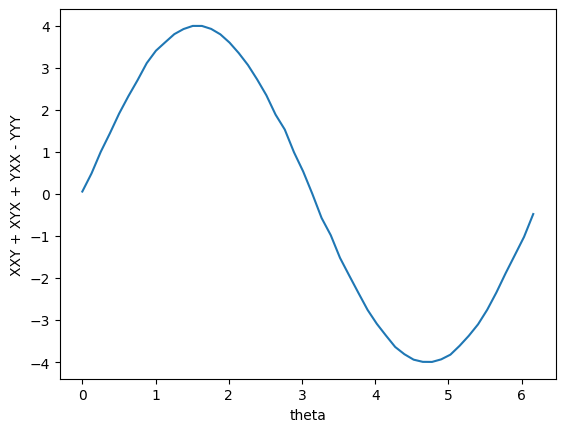

In [5]:
result = job.result()
import matplotlib.pyplot as plt


plt.plot(theta1, result.values)
plt.ylabel('XXY + XYX + YXX - YYY')
plt.xlabel('theta')
plt.show()

Now a powerful tool in the IBM Qiskit Runtime is the ability to use a session. A session allows you to lock the QPU and use it in an iterative manner. 

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Estimator, Session
service = QiskitRuntimeService()

options = Options(optimization_level=1)
options.execution.shots = 5000  # Options can be set using auto-complete.

# golden search method for finding max of M1 vs theta 
# https://en.wikipedia.org/wiki/Golden-section_search
gr = (np.sqrt(5) + 1) / 2

# range of theta  
thetaa = 0
thetab = 2*np.pi

#tol 
tol = 1e-1

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session, options=options)

    #next test range 
    thetac = thetab - (thetab - thetaa) / gr
    thetad = thetaa + (thetab - thetaa) / gr
    while abs(thetab - thetaa) > tol:
        
        print(f"max value of M1 is in the range theta = {[thetaa, thetab]}")
        job = estimator.run(circuits=[qc_example]*2, observables=[M1]*2, parameter_values=[[thetac],[thetad]])
        
        test =job.result().values
        if test[0] > test[1]:
            thetab = thetad
        else:
            thetaa = thetac
        
        thetac = thetab - (thetab - thetaa) / gr
        thetad = thetaa + (thetab - thetaa) / gr
        
    # Final Job to evaluate estimator at mid point found using golden search method 
    theta_mid = (thetab + thetaa) / 2
    job = estimator.run(circuits=qc_example, observables=M1, parameter_values=theta_mid)
    print(f"Session ID is {session.session_id}")
    print(f"Final Job ID is {job.job_id()}")
    print(f"Job result is {job.result().values} at theta = {theta_mid}")

max value of M1 is in the range theta = [0, 6.283185307179586]
max value of M1 is in the range theta = [0, 3.8832220774509327]
max value of M1 is in the range theta = [0, 2.399963229728653]
max value of M1 is in the range theta = [0.9167043820063734, 2.399963229728653]
max value of M1 is in the range theta = [0.9167043820063734, 1.8334087640127468]
max value of M1 is in the range theta = [1.2668542982968405, 1.8334087640127468]
max value of M1 is in the range theta = [1.4832588477222797, 1.8334087640127468]
max value of M1 is in the range theta = [1.4832588477222797, 1.6996633971477189]
max value of M1 is in the range theta = [1.4832588477222797, 1.6170042145873076]
Session ID is cjrtt7lr4b3c0j65fg1g
Final Job ID is cjrttflr4b3c0j65grjg
Job result is [4.] at theta = 1.575674623307102


Now we are going to move to the sampler. Here we simply show that the output of the circuit is 50/50. Suggesting that it is either entangled or mixed (this is one of the reasons why the estimator is so much more powerful as the primitive function can use near time compute and make this into doubles rather than samples)

In [7]:
# Step 2: Add a measurement using the compose function
qc_measure = QuantumCircuit(3,3)
qc_measure.measure_all(add_bits=False)
qc_compose = qc_example.compose(qc_measure)


# Step 3: choose the sampler and execute the quantum circuit. 
from qiskit.primitives.sampler import Sampler
sampler = Sampler()

job = sampler.run(qc_compose, shots=1000, parameter_values=np.pi/2)
result = job.result()
print(f" > Quasi probability distribution: {result.quasi_dists}")

 > Quasi probability distribution: [{0: 0.5, 7: 0.5}]


In [8]:
qc_compose.draw()

┌───┐┌──────┐           ░ ┌─┐      
q_0: ┤ H ├┤ P(θ) ├──■────■───░─┤M├──────
     └───┘└──────┘┌─┴─┐  │   ░ └╥┘┌─┐   
q_1: ─────────────┤ X ├──┼───░──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────────────┤ X ├─░──╫──╫─┤M├
                       └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
service = QiskitRuntimeService()

options = Options(optimization_level=1)
options.execution.shots = 1024  # Options can be set using auto-complete.


backend = service.get_backend('ibmq_qasm_simulator')

sampler = Sampler(backend=backend, options=options)
job = sampler.run(circuits=qc_compose, parameter_values=np.pi/2)
print(f"Job ID is {job.job_id()}")
print(f"Job result is {job.result()}")

Job ID is cjrtth4m0kng5pgpj4o0
Job result is SamplerResult(quasi_dists=[{7: 0.5087890625, 0: 0.4912109375}], metadata=[{'shots': 1024}])


As a last example Qiskit has a transpiler which is powerful and can help you map your quantum circuits to quantum hardware.

In [10]:
from qiskit.compiler import transpile
qc_ibm = transpile(qc_example, basis_gates = ['cz', 'sx', 'rz'], coupling_map =[[0, 1], [1, 2]] , optimization_level=3)
qc_ibm.draw()


┌─────────┐┌────┐ ┌───────┐                      ┌────┐  ┌─────────┐
q_2 -> 0 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├───────────────■──────┤ √X ├──┤ Rz(π/2) ├
         ├─────────┤├────┤┌┴───────┴┐┌───────┐     │      └────┘  └─────────┘
q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ) ├─■───■─────────────────────────
         ├─────────┤├────┤└┬───────┬┘└───────┘ │ ┌────┐┌─────────┐           
q_1 -> 2 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├───────────■─┤ √X ├┤ Rz(π/2) ├───────────
         └─────────┘└────┘ └───────┘             └────┘└─────────┘